In [3]:
import numpy as np
import readline
import rpy2
%load_ext rpy2.ipython

import os,sys
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
os.chdir("/scratch/nsturm/ExCAPE/XGboost_analysis/inner_folds/")

## Post-process raw prediction files

In [133]:
# this block is used to process each single task's file, which contains:
# the predictions for compounds in the test set for each given target for each tested set of hyperparameters
# there are 18 hyperparameters being tested.


for filename in os.listdir('.'):                                                                                                                                                                     
    if filename.endswith(".pickle") and filename.startswith("predict"): 
        data = []
        
        df=pd.read_pickle(filename)

        # each line in the report will start with fold info + target + hyperparameters
        # Each metrics report will be appended into the list "data"
        sample = filename.split('-')[1]
        ofold  = filename.split('-')[2]
        ifold  = filename.split('-')[3]
        al     = filename.split('-')[4]
        target_idx = filename.split('-')[5].replace('.pickle','')
        

        for hp in df['hyperparam'].unique():
            
            df_sub = df.loc[df['hyperparam']==hp]
            
            lr = hp.split('-')[1].replace('learning_rate_','')
            md = hp.split('-')[2].replace('max_depth_','')
            n_est = hp.split('-')[3].replace('n_estimators_','')
            w = hp.split('-')[-1].replace('scale_pos_weight_','')
            
            # verbose
            sys.stdout.write(filename+'::'+"-".join([lr,md,n_est,w])+',')
            
            y_true = df_sub['y_test'].values
            y_pred = df_sub['y_pred'].values
            
            
            # each metrics field is first appended into a "scores" list containing each element of the report
            scores = []
            scores.append(sample)                        # sample index (always = 1)
            scores.append(ofold)                         # outer fold index
            scores.append(ifold)                         # inner fold index
            scores.append(al)                            # activity level (always = 6)
            scores.append("-".join([lr,md,n_est,w]))     # hyperparamters
            scores.append(target_idx)                    # target index 
            scores.append(len(df_sub))                   # number of predictions (compounds in test set) 
            scores.append(log_loss(y_true, y_pred))      # logloss according to XGboost prediction score
            scores.append(roc_auc_score(y_true, y_pred)) # ROC-AUC
            scores.append(cohen_kappa_score(y_true, df_sub['y_pred_proba'].values)) # Kappa according to predicted classif (under y_pred_proba column name)
            
            
            
            # Compute perf metrics for 5 different prediction score cutoffs
            best_cutoff, best_f1, best_precision, best_kappa, best_tn, best_fp, best_fn, best_tp = -999,-999,-999,-999,-999,-999,-999,-999
            for cutoff in [0.3,0.4,0.5,0.6,0.7]:
                sys.stdout.write(str(cutoff)+'->')
                
                y_pred_classif = np.where(y_pred>=cutoff, 1, -1)
                prec_score     = precision_score(y_true, y_pred_classif)
                rec_score      = recall_score(y_true, y_pred_classif)
                kappa_score    = cohen_kappa_score(y_true, y_pred_classif)
                f1             = f1_score(y_true, y_pred_classif)               
                tn, fp, fn, tp  = confusion_matrix(y_true, y_pred_classif).ravel()
                
                
                # append each perf metrics into the record
                scores.append(tn)
                scores.append(fp)
                scores.append(fn)
                scores.append(tp)
                scores.append(prec_score)
                scores.append(rec_score)
                scores.append(kappa_score)
                scores.append(f1)

                # determine the best cutoff per target according to best f1-score (keep associated metrics)
                if f1 >= best_f1: 
                    best_f1 = f1
                    best_cutoff=cutoff
                    best_precision=prec_score
                    best_recall=rec_score
                    best_kappa = kappa_score
                    best_tn, best_fp, best_fn, best_tp = tn, fp, fn, tp
            
            
            # append perf metrics associated to best cutoff to the record
            scores.append(best_cutoff)
            scores.append(best_f1)
            scores.append(best_kappa)
            scores.append(best_precision)
            scores.append(best_recall)
            scores.append(best_tn)
            scores.append(best_fp)
            scores.append(best_fn)
            scores.append(best_tp)
                
            sys.stdout.write("\n")
            
            # add record to the general perf report
            data.append(scores)
        
        
        # once results specific to the target has been processed, form a dataframe and write into CSV
        dat_df = pd.DataFrame(data, columns=['sample', 'ofold', 'ifold', 'al', 'hp', 'target_idx', 'N_cmpds','logloss','AUC', 'kappa_pred_classif', 'T0.3_TN', 'T0.3_FP', 'T0.3_FN', 'T0.3_TP', 'T0.3_precision', 'T0.3_recall', 'T0.3_Kappa', 'T0.3_F1', 'T0.4_TN', 'T0.4_FP', 'T0.4_FN', 'T0.4_TP', 'T0.4_precision', 'T0.4_recall', 'T0.4_Kappa', 'T0.4_F1', 'T0.5_TN', 'T0.5_FP', 'T0.5_FN', 'T0.5_TP', 'T0.5_precision', 'T0.5_recall', 'T0.5_Kappa', 'T0.5_F1', 'T0.6_FN', 'T0.6_FP', 'T0.6_FN', 'T0.6_TP', 'T0.6_precision', 'T0.6_recall', 'T0.6_Kappa', 'T0.6_F1', 'T0.7_TN', 'T0.7_FP', 'T0.7_FN', 'T0.7_TP', 'T0.7_precision', 'T0.7_recall', 'T0.7_Kappa', 'T0.7_F1','best_cutoff','Max_F1','best_Kappa', 'precision', 'recall','tn','fp','fn','tp' ])
        dat_df.to_csv("results_"+"-".join([sample, ofold, ifold, al, target_idx])+".tsv", index=False)

        


predict-1-1-1-6-115.pickle::0.05-5-50-1,0.3->0.4->0.5->0.6->0.7->


In [12]:
# once each file is post-processed, we can pool all the results into on single file containing every thing

(1234566, 5)

## Plot Performances of inner folds

In [6]:
inner_df = pd.read_csv("all_inner_results_xgboost.tsv", header=0, sep=",")
cols2drop = [x for x in range(10, 50)]
inner_small = inner_df.drop(inner_df.columns[cols2drop], axis=1)
inner_small

,sample,ofold,ifold,al,hp,target_idx,N_cmpds,logloss,AUC,kappa_pred_classif,best_cutoff,Max_F1,best_Kappa,precision,recall,tn,fp,fn,tp
0,1,1,1,6,0.05-5-50-1,0,1485,0.527328,0.808374,0.507079,0.3,0.723493,0.467849,0.654135,0.809302,564,276,123,522
1,1,1,1,6,0.05-5-50-5,0,1485,0.633088,0.804593,0.404244,0.6,0.722067,0.468159,0.656925,0.801550,570,270,128,517
2,1,1,1,6,0.05-5-50-10,0,1485,0.757278,0.792723,0.253211,0.7,0.713137,0.434029,0.628099,0.824806,525,315,113,532
3,1,1,1,6,0.05-5-100-1,0,1485,0.531826,0.810966,0.495144,0.3,0.730314,0.483130,0.663291,0.812403,574,266,121,524
4,1,1,1,6,0.05-5-100-5,0,1485,0.643454,0.810930,0.412486,0.6,0.726634,0.479363,0.664524,0.801550,579,261,128,517
5,1,1,1,6,0.05-5-100-10,0,1485,0.765975,0.807226,0.323805,0.7,0.729380,0.472733,0.650852,0.829457,553,287,110,535
6,1,1,1,6,0.05-5-200-1,0,1485,0.537328,0.813647,0.514753,0.4,0.737850,0.518024,0.702665,0.776744,628,212,144,501
7,1,1,1,6,0.05-5-200-5,0,1485,0.634112,0.815267,0.431503,0.7,0.733791,0.523520,0.722222,0.745736,655,185,164,481
8,1,1,1,6,0.05-5-200-10,0,1485,0.747380,0.809578,0.373858,0.6,0.719844,0.433656,0.618729,0.860465,498,342,90,555
9,1,1,1,6,0.05-10-50-1,0,1485,0.530738,0.811167,0.475750,0.4,0.731559,0.518404,0.717910,0.745736,651,189,164,481


In [7]:
df_means = inner_small.groupby(['hp','target_idx']).mean().reset_index()
METRIC='AUC'

In [73]:
k=0
data = []
for target_idx in df_means['target_idx'].unique():
    data.append(df_means.loc[df_means['target_idx']==target_idx].sort_values(by=[METRIC], ascending=False).head(1).values[0])
#    k+=1
#    if k==4: break



In [78]:
best_perf_per_target_inner = pd.DataFrame(data, columns=df_means.columns.values)
best_perf_per_target_inner.head()

,hp,target_idx,sample,ofold,ifold,al,N_cmpds,logloss,AUC,kappa_pred_classif,best_cutoff,Max_F1,best_Kappa,precision,recall,tn,fp,fn,tp
0,0.05-10-200-1,0,1.0,2.0,1.5,6.0,1758.333333,0.533710,0.839128,0.542297,0.333333,0.784540,0.549159,0.754553,0.820680,623.166667,242.500000,156.500000,736.166667
1,0.05-5-200-1,1,1.0,2.0,1.5,6.0,718.000000,0.453503,0.891197,0.641129,0.350000,0.823961,0.657266,0.820976,0.828326,300.833333,60.500000,60.333333,296.333333
2,0.05-5-200-1,2,1.0,2.0,1.5,6.0,72353.333333,0.049538,0.684604,0.028322,0.300000,0.059642,0.058619,0.510419,0.031918,71642.500000,20.500000,668.333333,22.000000
3,0.05-5-200-1,3,1.0,2.0,1.5,6.0,135447.000000,0.006856,0.794952,-0.000014,0.583333,0.007671,0.007646,0.120370,0.004034,135316.666667,1.333333,128.500000,0.500000
4,0.05-5-200-1,4,1.0,2.0,1.5,6.0,113335.333333,0.061178,0.657428,0.004572,0.300000,0.013643,0.013210,0.374912,0.006975,111982.166667,16.166667,1327.666667,9.333333


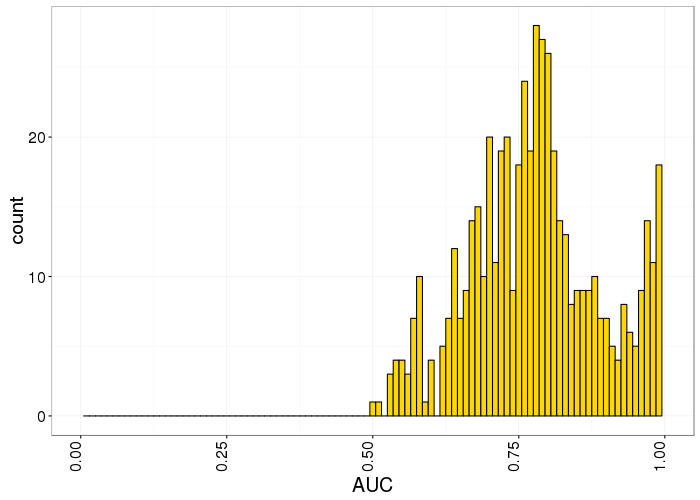

In [123]:
%%R -w 700 -h 500 -u px -i best_perf_per_target_inner,METRIC
library(ggplot2)

# set the theme styles
theme<-theme_bw()+theme(text=element_text(size=20), 
                        axis.text.x=element_text(angle=90, vjust=0, hjust=1), 
                        legend.position="bottom"
                       )
theme_set(theme)

# define aestetics
g<-ggplot(best_perf_per_target_inner, aes(AUC))

# create the plot object
g+geom_histogram(binwidth = 0.01, fill="gold", col="black")+xlim(0.0,1)

## Plot performances of outer folds

In [98]:
os.chdir("/scratch/nsturm/ExCAPE/XGboost_analysis/outer_folds/")

In [99]:
outer_df = pd.read_csv("all_outer_results_xgboost.tsv", header=0, sep=",")
cols2drop = [x for x in range(10, 50)]
outer_small = outer_df.drop(outer_df.columns[cols2drop], axis=1)
outer_small.head()

,sample,ofold,ifold,al,hp,target_idx,N_cmpds,logloss,AUC,kappa_pred_classif,best_cutoff,Max_F1,best_Kappa,precision,recall,tn,fp,fn,tp
0,1,1,0,6,0.05-5-50-1,0,2326,0.511851,0.834133,0.514296,0.4,0.801444,0.512507,0.750507,0.859799,666,369,181,1110
1,1,1,0,6,0.05-5-50-5,0,2326,0.580992,0.834187,0.426129,0.6,0.814636,0.518059,0.734745,0.914020,609,426,111,1180
2,1,1,0,6,0.05-5-50-10,0,2326,0.667032,0.824080,0.266715,0.7,0.806849,0.492674,0.723143,0.912471,584,451,113,1178
3,1,1,0,6,0.05-5-100-1,0,2326,0.497533,0.840074,0.525144,0.4,0.801887,0.516712,0.754266,0.855926,675,360,186,1105
4,1,1,0,6,0.05-5-100-5,0,2326,0.585199,0.845933,0.440161,0.7,0.817497,0.548009,0.761015,0.883036,677,358,151,1140


In [125]:
df_means_out = outer_small.groupby(['hp','target_idx']).mean().reset_index()

In [104]:
best_perf_per_target_inner.head()

,hp,target_idx,sample,ofold,ifold,al,N_cmpds,logloss,AUC,kappa_pred_classif,best_cutoff,Max_F1,best_Kappa,precision,recall,tn,fp,fn,tp
0,0.05-10-200-1,0,1.0,2.0,1.5,6.0,1758.333333,0.533710,0.839128,0.542297,0.333333,0.784540,0.549159,0.754553,0.820680,623.166667,242.500000,156.500000,736.166667
1,0.05-5-200-1,1,1.0,2.0,1.5,6.0,718.000000,0.453503,0.891197,0.641129,0.350000,0.823961,0.657266,0.820976,0.828326,300.833333,60.500000,60.333333,296.333333
2,0.05-5-200-1,2,1.0,2.0,1.5,6.0,72353.333333,0.049538,0.684604,0.028322,0.300000,0.059642,0.058619,0.510419,0.031918,71642.500000,20.500000,668.333333,22.000000
3,0.05-5-200-1,3,1.0,2.0,1.5,6.0,135447.000000,0.006856,0.794952,-0.000014,0.583333,0.007671,0.007646,0.120370,0.004034,135316.666667,1.333333,128.500000,0.500000
4,0.05-5-200-1,4,1.0,2.0,1.5,6.0,113335.333333,0.061178,0.657428,0.004572,0.300000,0.013643,0.013210,0.374912,0.006975,111982.166667,16.166667,1327.666667,9.333333


In [126]:
# use the hyperparamters of best model based on results found in inner folds

## make a dictionary target --> model
target_hp = {}
for idx, row in best_perf_per_target_inner.iterrows():
    target_hp[row[1]] = row[0]

In [127]:
data = []
for target_idx, hp in target_hp.items(): 
    data.append(df_means_out.loc[(df_means_out['target_idx']==target_idx)&(df_means_out['hp']==hp)].values[0])
    

In [128]:
perf_per_target_outer = pd.DataFrame(data, columns=df_means.columns.values)

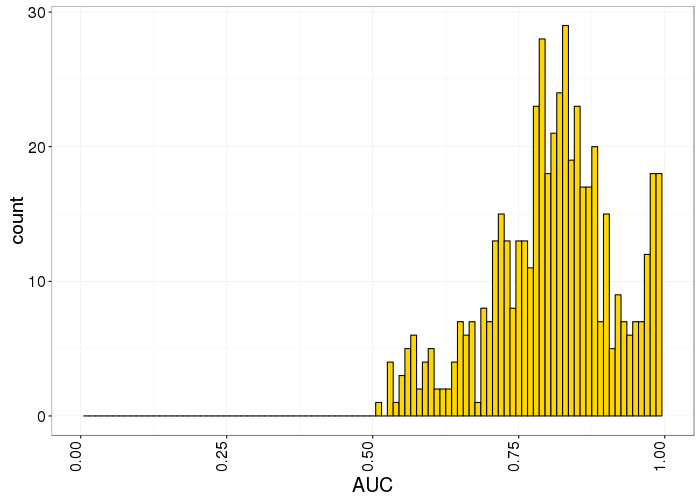

In [129]:
%%R -w 700 -h 500 -u px -i perf_per_target_outer,METRIC
library(ggplot2)

# set the theme styles
theme<-theme_bw()+theme(text=element_text(size=20), 
                        axis.text.x=element_text(angle=90, vjust=0, hjust=1), 
                        legend.position="bottom"
                       )
theme_set(theme)

# define aestetics
g<-ggplot(perf_per_target_outer, aes(AUC))

# create the plot object
g+geom_histogram(binwidth = 0.01, fill="gold", col="black")+xlim(0.0,1)

## Combine results to ExNET's perf

In [131]:
os.chdir("/scratch/nsturm/ExCAPE/ExNET_analysis")
outer_df = pd.read_csv("all_outer_metrics.tsv", header=0, sep="\t")

In [142]:
bom_df = outer_df.loc[(outer_df['network']=='2048_2048')&(outer_df['param']=='0_1-0_5-0_8-0_4')&(outer_df['step']==480000)]

In [150]:
means_df_exnet_out = bom_df.groupby(['target']).mean().reset_index()

cols2drop = [x for x in range(8, 44)]
means_df_exnet_out2 = means_df_exnet_out.drop(means_df_exnet_out.columns[cols2drop], axis=1)
means_df_exnet_out2.head()

,target,sample,ofold,ifold,al,step,logloss,AUC
0,0,1.0,2.0,0.0,6.0,480000.0,0.573567,0.797836
1,1,1.0,2.0,0.0,6.0,480000.0,0.588144,0.816338
2,2,1.0,2.0,0.0,6.0,480000.0,0.052665,0.638224
3,3,1.0,2.0,0.0,6.0,480000.0,0.007176,0.787148
4,4,1.0,2.0,0.0,6.0,480000.0,0.061359,0.666098


In [158]:
cols2drop = [x for x in range(9, 19)]
perf_per_target_outer2 = perf_per_target_outer.drop(perf_per_target_outer.columns[cols2drop], axis=1)

In [165]:
means_df_exnet_out2.head()

,target,sample,ofold,ifold,al,step,logloss,AUC
0,0,1.0,2.0,0.0,6.0,480000.0,0.573567,0.797836
1,1,1.0,2.0,0.0,6.0,480000.0,0.588144,0.816338
2,2,1.0,2.0,0.0,6.0,480000.0,0.052665,0.638224
3,3,1.0,2.0,0.0,6.0,480000.0,0.007176,0.787148
4,4,1.0,2.0,0.0,6.0,480000.0,0.061359,0.666098


In [166]:
means_df_exnet_out2.merge(perf_per_target_outer2, left_on='target', right_on='target_idx').head()

,target,sample_x,ofold_x,ifold_x,al_x,step,logloss_x,AUC_x,hp,target_idx,sample_y,ofold_y,ifold_y,al_y,N_cmpds,logloss_y,AUC_y
0,0,1.0,2.0,0.0,6.0,480000.0,0.573567,0.797836,0.05-10-200-1,0,1.0,2.0,0.0,6.0,1758.333333,0.467322,0.865804
1,1,1.0,2.0,0.0,6.0,480000.0,0.588144,0.816338,0.05-5-200-1,1,1.0,2.0,0.0,6.0,718.000000,0.368916,0.914670
2,2,1.0,2.0,0.0,6.0,480000.0,0.052665,0.638224,0.05-5-200-1,2,1.0,2.0,0.0,6.0,72353.333333,0.048398,0.707520
3,3,1.0,2.0,0.0,6.0,480000.0,0.007176,0.787148,0.05-5-200-1,3,1.0,2.0,0.0,6.0,135447.000000,0.006578,0.825503
4,4,1.0,2.0,0.0,6.0,480000.0,0.061359,0.666098,0.05-5-200-1,4,1.0,2.0,0.0,6.0,113335.333333,0.060372,0.673001


In [160]:
comp_df = means_df_exnet_out2.merge(perf_per_target_outer2, left_on='target', right_on='target_idx')

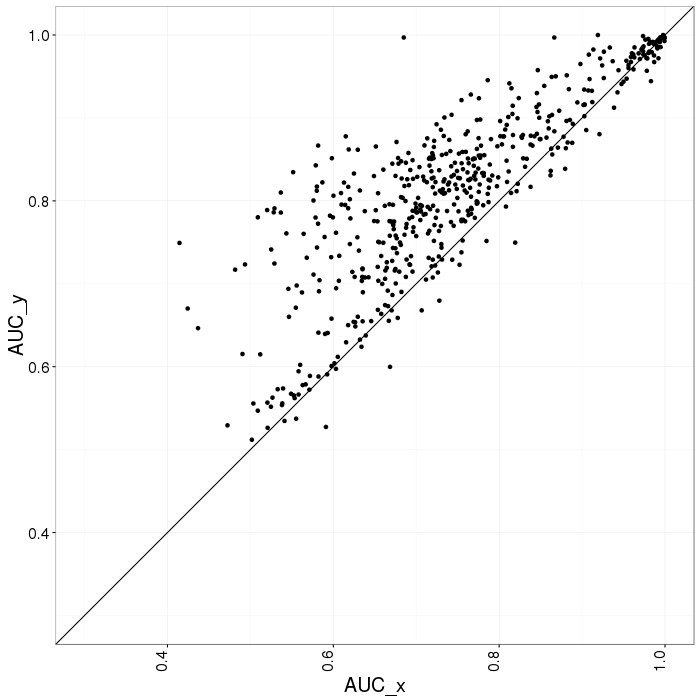

In [163]:
%%R -w 700 -h 700 -u px -i comp_df
library(ggplot2)

# set the theme styles
theme<-theme_bw()+theme(text=element_text(size=20), 
                        axis.text.x=element_text(angle=90, vjust=0, hjust=1), 
                        legend.position="bottom"
                       )
theme_set(theme)

# define aestetics
g<-ggplot(comp_df, aes(x=AUC_x, y=AUC_y))

# create the plot object
g + geom_point() + 
    geom_abline(slope=1) + 
    xlim(0.3,1)+
    ylim(0.3,1)